Importing Libraries

In [38]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Setting Time Range and Ticker List

In [39]:
#Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

#Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

Downloading Adjusted Close Prices

In [40]:
#Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-06-26   95.750587  48.785194   90.610001   39.963528   48.588211
2008-06-27   95.227898  48.913925   91.470001   39.963528   48.520237
2008-06-30   95.563927  49.074821   91.400002   39.543320   48.422016
2008-07-01   95.862633  49.039932   92.660004   40.103600   48.648666
2008-07-02   94.219841  48.871933   93.169998   39.140633   47.651360
...                ...        ...         ...         ...         ...
2023-06-15  440.962006  72.889999  181.910004  369.752808  220.089996
2023-06-16  439.459991  7

Calculating Daily Log Returns

In [41]:
#Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-06-27 -0.005474  0.002635  0.009446  0.000000 -0.001400
2008-06-30  0.003522  0.003284 -0.000766 -0.010570 -0.002026
2008-07-01  0.003121 -0.000711  0.013691  0.014069  0.004670
2008-07-02 -0.017285 -0.003432  0.005489 -0.024305 -0.020713
2008-07-03  0.001030  0.000793 -0.011985 -0.001791 -0.000952
...              ...       ...       ...       ...       ...
2023-06-15  0.012321  0.006193  0.007006  0.011845  0.012114
2023-06-16 -0.003412 -0.002197 -0.001540 -0.006313 -0.003778
2023-06-20 -0.005202  0.001374 -0.010405 -0.001433 -0.004938
2023-06-21 -0.005137  0.001646 -0.001447 -0.013721 -0.005515
2023-06-22  0.003603 -0.004809 -0.009966  0.011730  0.002669

[3772 rows x 5 columns]


Defining Functions to Calculate Portfolio Expected Return and Standard Deviation

In [42]:
#Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

#Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Creating a Covariance Matrix

In [43]:
#Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.687081e-04 -1.512426e-07  0.000006  1.723636e-04  1.693624e-04
BND -1.512426e-07  1.068074e-05  0.000009 -4.459099e-07 -2.331776e-07
GLD  6.134751e-06  8.626154e-06  0.000120  5.194282e-06  7.379486e-06
QQQ  1.723636e-04 -4.459099e-07  0.000005  2.055943e-04  1.744722e-04
VTI  1.693624e-04 -2.331776e-07  0.000007  1.744722e-04  1.721565e-04


Calculating Portfolio Expected Return and Standard Deviation

In [44]:
#Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

Defining Functions for Monte Carlo Simulation

In [45]:
def random_z_score():
    return np.random.normal(0, 1)

#Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

Running Monte Carlo Simulation

In [46]:
#Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

Calculating Value at Risk (VaR)

In [47]:
#Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.95
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

55869.18374908318


Plotting the Results

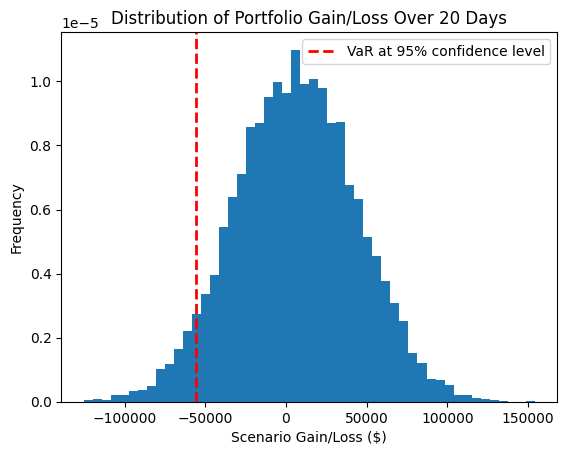

In [48]:
#Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()